# Tutorial for mapping data with Tangram

- The notebook introduces to mapping single cell data on spatial data by using Tangram.
- The notebook was used to integrate scRNAseq (dev lung) with ISS datasets (pcw5,6 and 13)

***
#### Installation

- Make sure `tangram-sc` is installed via `pip install tangram-sc`.
- The Python environment needs to have installed the packages listed in `environment.yml`.

In [24]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

***
#### Load spatial data
- Spatial data need to be organized as a voxel-by-gene matrix. Here, Slide-seq data contains 9852 spatial voxels, in each of which there are 24518 genes measured. Spatial data can be obtained from TissUUmaps https://tissuumaps.dckube.scilifelab.se/web/private/HDCA/index.html

In [25]:
dat=pd.read_csv('J:/MAIN_LUNG_DATA/PCISEQ_maps/S6T3_pciseq_results.csv')

In [26]:
exp=dat.iloc[:,0:100]
meta=dat.iloc[:,100:106]

In [27]:
meta

,name,X,Y,cluster_0_,cluster_1_,cluster_10_
0,cluster_1_,540.5,1220.5,0.156152,0.188063,2.964036e-05
1,cluster_25_,580.5,3700.5,0.064955,0.072839,5.368714e-06
2,cluster_20_,1100.5,3020.5,0.007186,0.008341,1.839034e-04
3,cluster_20_,1100.5,3060.5,0.000264,0.000157,3.475873e-05
4,cluster_20_,1100.5,3100.5,0.000949,0.000512,6.834226e-02
...,...,...,...,...,...,...
3124,cluster_20_,4220.5,3820.5,0.017771,0.011829,3.018401e-04
3125,cluster_8_,4220.5,3860.5,0.002211,0.001707,1.330060e-11
3126,cluster_14_,4220.5,3900.5,0.001794,0.002863,1.896850e-06
3127,cluster_18_,4260.5,3620.5,0.033359,0.022770,1.342286e-02


In [28]:
adata=sc.AnnData(exp)
adata.X=adata.X.astype('int64')

C:\Users\sergio.salas\Miniconda3\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
adata.obs=meta
adatasub=adata
ad_sp = adatasub
ad_sp.obs['y']=ad_sp.obs['Y']
ad_sp.obs['x']=ad_sp.obs['X']

- The voxel coordinates are saved in the fields `obs.x` and `obs.y` which we can use to visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

In [30]:
np.sum(adata.X,axis=1)

array([ 7,  5, 13, ..., 20, 13, 11], dtype=int64)

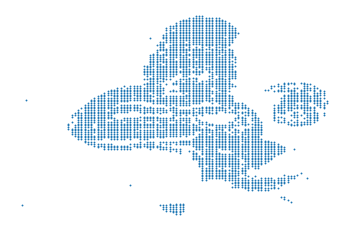

In [31]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

***
#### Single cell data

- By single cell data, we generally mean either scRNAseq or snRNAseq.
- We start by mapping the MOp 10Xv3 dataset, which contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 26k profiled cells with 28k genes.

In [32]:
RNA_data=pd.read_csv('J:/SPAGE2VEC_INPUT/sample_analysis_allcells_from_pcw13_3.tsv',sep='/t')
RNA_meta=pd.read_csv('J:/SPAGE2VEC_INPUT/sample_analysis2_meta_allcells_from_pcw13_3.tsv',sep='/t')


<ipython-input-32-c0cf31a5fc94>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  RNA_data=pd.read_csv('J:/SPAGE2VEC_INPUT/sample_analysis_allcells_from_pcw13_3.tsv',sep='/t')
<ipython-input-32-c0cf31a5fc94>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  RNA_meta=pd.read_csv('J:/SPAGE2VEC_INPUT/sample_analysis2_meta_allcells_from_pcw13_3.tsv',sep='/t')


In [33]:
RNA_data.shape

(25534, 6579)

In [34]:
RNA_data.index = RNA_data.index.str.replace('"', "")

In [35]:
RNA_data.index = RNA_data.index.str.replace('"', "")

In [22]:
#sel=RNA_data.index.isin(ad_sp.var.index)


In [23]:
#RNA_data=RNA_data[sel]

In [36]:

scdata=sc.AnnData(RNA_data.iloc[:,1:RNA_data.shape[1]].transpose())

In [37]:
scdata

AnnData object with n_obs × n_vars = 6578 × 25534

In [38]:
RNA_meta.shape

(6579, 90)

In [39]:
RNA_meta=RNA_meta.iloc[1:6579,:]

In [40]:

scdata.obs=RNA_meta
scdata.var.index=RNA_data.index
ad_sc=scdata

- Usually, we work with data in raw count form, especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [41]:
ad_sc=scdata

In [42]:
ad_sc.X.shape

(6578, 25534)

- Here, we only do some light pre-processing as library size correction (in scanpy, via `sc.pp.normalize`) to normalize the number of count within each cell to a fixed number.
- Sometimes, we apply more sophisticated pre-processing methods, for example for batch correction, although mapping works great with raw data.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible and the pre-processing pipeline should be finalized to harmonize the signals.

In [43]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, cell types are annotated in the `subclass_label` field, for which we plot cell counts.
- Note that cell type proportion should be similar in the two datasets: for example, if `Meis` is a rare cell type in the snRNA-seq then it is expected to be a rare one even in the spatial data as well.

In [44]:
ad_sc.obs

,"""orig.ident""","""nCount_RNA""","""nFeature_RNA""","""Clusters""","""DoubletFinderFlag""","""DoubletFinderScore""","""MT_ratio""","""NGenes""","""PassedQC""","""PassedQC_MT_ratio""",...,"""DF.classifications_0.25_0.09_489""","""pANN_0.25_0.01_680""","""DF.classifications_0.25_0.01_680""","""pANN_0.25_0.02_191""","""DF.classifications_0.25_0.02_191""","""pANN_0.25_0.03_1012""","""DF.classifications_0.25_0.03_1012""","""pANN_0.25_0.05_170""","""DF.classifications_0.25_0.05_170""","""integrated_snn_res.0.8"""
"""10X214_1_ABC_1:AACGAAATCTCGTGGGx""","""10X214""",16012,4774,5,0,0.130435,0.030975,4775,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""8"""
"""10X214_1_ABC_1:AAAGGGCTCGTCTCACx""","""10X214""",5218,2281,1,0,0.000000,0.072442,2281,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""0"""
"""10X214_1_ABC_1:AAACGCTTCTGCACCTx""","""10X214""",16035,4449,1,0,0.217391,0.009915,4450,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""3"""
"""10X214_1_ABC_1:AAACGAAGTCAGGTAGx""","""10X214""",11545,4079,6,0,0.108696,0.042010,4079,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""6"""
"""10X214_1_ABC_1:AACCACACACATTCTTx""","""10X214""",9096,3388,7,0,0.152174,0.023085,3389,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""6"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""10X214_2_ABC_1:TTTGTTGAGCGTCAGAx""","""10X214""",13465,4477,6,0,0.076087,0.045374,4478,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""8"""
"""10X214_2_ABC_1:TTTGTTGGTTGCCAATx""","""10X214""",13498,4138,9,0,0.206522,0.019261,4139,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""3"""
"""10X214_2_ABC_1:TTTGGTTGTACGTTCAx""","""10X214""",11456,3903,1,0,0.076087,0.025225,3904,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""5"""
"""10X214_2_ABC_1:TTTGTTGGTCCACGCAx""","""10X214""",10804,3640,1,0,0.032609,0.024528,3640,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""5"""


In [45]:
ad_sc.obs.columns

Index(['"orig.ident"', '"nCount_RNA"', '"nFeature_RNA"', '"Clusters"',
       '"DoubletFinderFlag"', '"DoubletFinderScore"', '"MT_ratio"', '"NGenes"',
       '"PassedQC"', '"PassedQC_MT_ratio"', '"PassedQC_TotalUMI"',
       '"PassedQC_UMIPerGene"', '"PassedQC_UnsplicedRatio"', '"TotalUMI"',
       '"X_X"', '"X_Y"', '"unspliced_ratio"', '"chemistry"', '"age"',
       '"orig_ident"', '"name"', '"SampleName"', '"donor"', '"percent.MT"',
       '"nCount_spliced"', '"nFeature_spliced"', '"nCount_unspliced"',
       '"nFeature_unspliced"', '"nCount_ambiguous"', '"nFeature_ambiguous"',
       '"nCount_SCT"', '"nFeature_SCT"', '"SCT_snn_res.0.8"',
       '"seurat_clusters"', '"SCT_snn_res.0.1"', '"SCT_snn_res.0.2"',
       '"SCT_snn_res.0.3"', '"SCT_snn_res.0.4"', '"SCT_snn_res.0.5"',
       '"SCT_snn_res.0.6"', '"SCT_snn_res.0.7"', '"SCT_snn_res.0.9"',
       '"SCT_snn_res.1"', '"SCT_snn_res.1.1"', '"SCT_snn_res.1.2"',
       '"SCT_snn_res.1.3"', '"SCT_snn_res.1.4"', '"SCT_snn_res.1.5"',
   

In [46]:
ad_sc.obs['subclass_label']=ad_sc.obs['"seurat_clusters"']

In [35]:
ad_sc.obs.subclass_label.value_counts()

"0"     904
"1"     776
"6"     477
"7"     463
"2"     409
"8"     397
"5"     372
"13"    351
"16"    338
"4"     318
"3"     300
"9"     278
"10"    275
"12"    192
"14"    119
"17"    111
"11"     96
"15"     93
"19"     80
"18"     69
"24"     39
"22"     29
"26"     27
"21"     22
"20"     18
"27"     10
"23"      8
"28"      6
"29"      1
Name: subclass_label, dtype: int64

***
#### Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- In doing this, Tangram only looks at a subset genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types. Sometimes, we also use the entire transcriptome, or perform different mappings using different set of training genes to see how much the result change.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [47]:
ad_sp.obs

,name,X,Y,cluster_0_,cluster_1_,cluster_10_,y,x
0,cluster_1_,540.5,1220.5,0.156152,0.188063,2.964036e-05,1220.5,540.5
1,cluster_25_,580.5,3700.5,0.064955,0.072839,5.368714e-06,3700.5,580.5
2,cluster_20_,1100.5,3020.5,0.007186,0.008341,1.839034e-04,3020.5,1100.5
3,cluster_20_,1100.5,3060.5,0.000264,0.000157,3.475873e-05,3060.5,1100.5
4,cluster_20_,1100.5,3100.5,0.000949,0.000512,6.834226e-02,3100.5,1100.5
...,...,...,...,...,...,...,...,...
3124,cluster_20_,4220.5,3820.5,0.017771,0.011829,3.018401e-04,3820.5,4220.5
3125,cluster_8_,4220.5,3860.5,0.002211,0.001707,1.330060e-11,3860.5,4220.5
3126,cluster_14_,4220.5,3900.5,0.001794,0.002863,1.896850e-06,3900.5,4220.5
3127,cluster_18_,4260.5,3620.5,0.033359,0.022770,1.342286e-02,3620.5,4260.5


In [48]:
ad_sp.var.index

Index(['ARIH1', 'ATP11A', 'BCL2', 'CCBE1', 'CCL21', 'CD36', 'CD74', 'CD93',
       'CDON', 'CLDN5', 'COL11A1', 'COL13A1', 'COL9A3', 'CPM', 'CTGF',
       'CTNND2', 'DLL1', 'DLL3', 'DMD', 'DNAH12', 'EBF1', 'EDN1', 'EGFL6',
       'EPCAM', 'ETS1', 'ETS2', 'ETV3', 'ETV5', 'FAM162B', 'FGF2', 'FGF20',
       'FGF9', 'FGFR1', 'FGFR2', 'FGFR4', 'FLT4', 'FZD2', 'FZD3', 'FZD7',
       'GLI2', 'GLI3', 'GRP', 'HEY1', 'HEYL', 'HGF', 'IGF1', 'IGFBP5',
       'IGFBP7', 'ITGA8', 'JAG1', 'KDR', 'KLRB1', 'LEF1', 'LRP1B', 'LRP2',
       'LRP5', 'LTB', 'LXN', 'MET', 'MFNG', 'MGP', 'MYH11', 'NKD1', 'NOTCH1',
       'NOTCH2', 'NOTCH3', 'NOTCH4', 'NOTUM', 'PDGFA', 'PDGFB', 'PDGFRA',
       'PDGFRB', 'PECAM1', 'PHOX2B', 'PRKCB', 'PTCH1', 'RELN', 'RGS7',
       'RNASE1', 'RSPH1', 'RSPO3', 'S100A9', 'SAMD4A', 'SFRP1', 'SFRP2',
       'SFTPC', 'SMO', 'SOX17', 'SPRY1', 'SRGN', 'STAT3', 'TCIM', 'TECRL',
       'TPPP3', 'VEGFC', 'VEGFD', 'WIF1', 'WNT5A', 'WNT7B', 'WT1'],
      dtype='object')

In [49]:
markers=np.unique(ad_sp.var.index)
#markers = list(markers)
len(markers)

100

- We now need to prepare the datasets for mapping: the two `AnnData` structures need to be subset on the list of training genes.
- Also, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- And if data entries of a gene are all zero, this gene will be removed
- This task is performed by the helper `pp_adatas`.

In [50]:
ad_sc.var_names_make_unique()

In [51]:
ad_sc.var


""
AL627309.1
LINC00115
FAM41C
AL645608.1
NOC2L
...
USP9Y
DDX3Y
TMSB4Y
NLGN4Y


In [41]:
ad_sp.var.index.names=['col']

In [42]:
ad_sc, ad_sp = tg.pp_adatas(ad_sc, ad_sp, genes=markers)

C:\Users\sergio.salas\Miniconda3\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `pp_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [43]:
ad_sc

View of AnnData object with n_obs × n_vars = 6578 × 100
    obs: '"orig.ident"', '"nCount_RNA"', '"nFeature_RNA"', '"Clusters"', '"DoubletFinderFlag"', '"DoubletFinderScore"', '"MT_ratio"', '"NGenes"', '"PassedQC"', '"PassedQC_MT_ratio"', '"PassedQC_TotalUMI"', '"PassedQC_UMIPerGene"', '"PassedQC_UnsplicedRatio"', '"TotalUMI"', '"X_X"', '"X_Y"', '"unspliced_ratio"', '"chemistry"', '"age"', '"orig_ident"', '"name"', '"SampleName"', '"donor"', '"percent.MT"', '"nCount_spliced"', '"nFeature_spliced"', '"nCount_unspliced"', '"nFeature_unspliced"', '"nCount_ambiguous"', '"nFeature_ambiguous"', '"nCount_SCT"', '"nFeature_SCT"', '"SCT_snn_res.0.8"', '"seurat_clusters"', '"SCT_snn_res.0.1"', '"SCT_snn_res.0.2"', '"SCT_snn_res.0.3"', '"SCT_snn_res.0.4"', '"SCT_snn_res.0.5"', '"SCT_snn_res.0.6"', '"SCT_snn_res.0.7"', '"SCT_snn_res.0.9"', '"SCT_snn_res.1"', '"SCT_snn_res.1.1"', '"SCT_snn_res.1.2"', '"SCT_snn_res.1.3"', '"SCT_snn_res.1.4"', '"SCT_snn_res.1.5"', '"SCT_snn_res.1.6"', '"SCT_snn_res.1

In [44]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is possible to save the structures, then restart the python kernel.

In [46]:
ad_sc.write_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_sc_readytomap_pcw5PCISEQ.h5ad')
ad_sp.write_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_sp_readytomap_pcw5PCISEQ.h5ad')

***
#### Map

In [7]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import tangram as tg

In [8]:
ad_sp = sc.read_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_sp_readytomap_pcw5PCISEQ.h5ad')
ad_sc = sc.read_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_sc_readytomap_pcw5PCISEQ.h5ad')

- We can now train the model (_ie_ map the single cell data onto space).
- Mapping should be interrupted after the score plateaus,which can be controlled by passing the `num_epochs` parameter. 
- The score measures the similarity between the gene expression of the mapped cells vs spatial data: higher score means better mapping
- Note that we obtained excellent mapping even if Tangram converges to a low scores (the typical case is when the spatial data are very sparse): we use the score merely to assess convergence.
- If you are running Tangram with a GPU, uncomment `device=cuda:0` and comment the line `device=cpu`. On a MacBook Pro 2018, it takes ~1h to run. On a P100 GPU it should be done in a few minutes.
- For this basic mapping, we do not use regularizers. More sophisticated loss functions can be used using the Tangram library (refer to manuscript or dive into the code).
- We can map at cluster-level single cell data instead of cell level data (refer to manuscript or dive into the code), which is faster and requires less memory. In this notebook, we are mapping at individual cell level.

In [23]:
ad_sc

AnnData object with n_obs × n_vars = 6578 × 100
    obs: '"orig.ident"', '"nCount_RNA"', '"nFeature_RNA"', '"Clusters"', '"DoubletFinderFlag"', '"DoubletFinderScore"', '"MT_ratio"', '"NGenes"', '"PassedQC"', '"PassedQC_MT_ratio"', '"PassedQC_TotalUMI"', '"PassedQC_UMIPerGene"', '"PassedQC_UnsplicedRatio"', '"TotalUMI"', '"X_X"', '"X_Y"', '"unspliced_ratio"', '"chemistry"', '"age"', '"orig_ident"', '"name"', '"SampleName"', '"donor"', '"percent.MT"', '"nCount_spliced"', '"nFeature_spliced"', '"nCount_unspliced"', '"nFeature_unspliced"', '"nCount_ambiguous"', '"nFeature_ambiguous"', '"nCount_SCT"', '"nFeature_SCT"', '"SCT_snn_res.0.8"', '"seurat_clusters"', '"SCT_snn_res.0.1"', '"SCT_snn_res.0.2"', '"SCT_snn_res.0.3"', '"SCT_snn_res.0.4"', '"SCT_snn_res.0.5"', '"SCT_snn_res.0.6"', '"SCT_snn_res.0.7"', '"SCT_snn_res.0.9"', '"SCT_snn_res.1"', '"SCT_snn_res.1.1"', '"SCT_snn_res.1.2"', '"SCT_snn_res.1.3"', '"SCT_snn_res.1.4"', '"SCT_snn_res.1.5"', '"SCT_snn_res.1.6"', '"SCT_snn_res.1.7"', '"

In [49]:
ad_map = tg.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
    device='cpu',num_epochs=500
    # device='cuda:0',
)

Score: 0.238, KL reg: nan, VG reg: nan
Score: 0.855, KL reg: nan, VG reg: nan
Score: 0.863, KL reg: nan, VG reg: nan
Score: 0.864, KL reg: nan, VG reg: nan
Score: 0.865, KL reg: nan, VG reg: nan


- The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
    - The cell-by-spot matrix `X` contains the probability of cell $i$ to be in spot $j$.
    - The `obs` dataframe contains the metadata of the single cells.
    - The `var` dataframe contains the metadata of the spatial data.
    - The `uns` dictionary contains a dataframe with various information about the training genes (saved ad `train_genes_df`).
- We can now save the mapping results for post-analysis.

In [50]:
ad_map.write_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_mapALLSUBSET_pcw5_pciseq.h5ad')

In [12]:
ad_map=sc.read_h5ad('J:/HDCA_LUNG_Test3/Decoded_files/ad_mapALLSUBSET_pcw5_pciseq.h5ad')

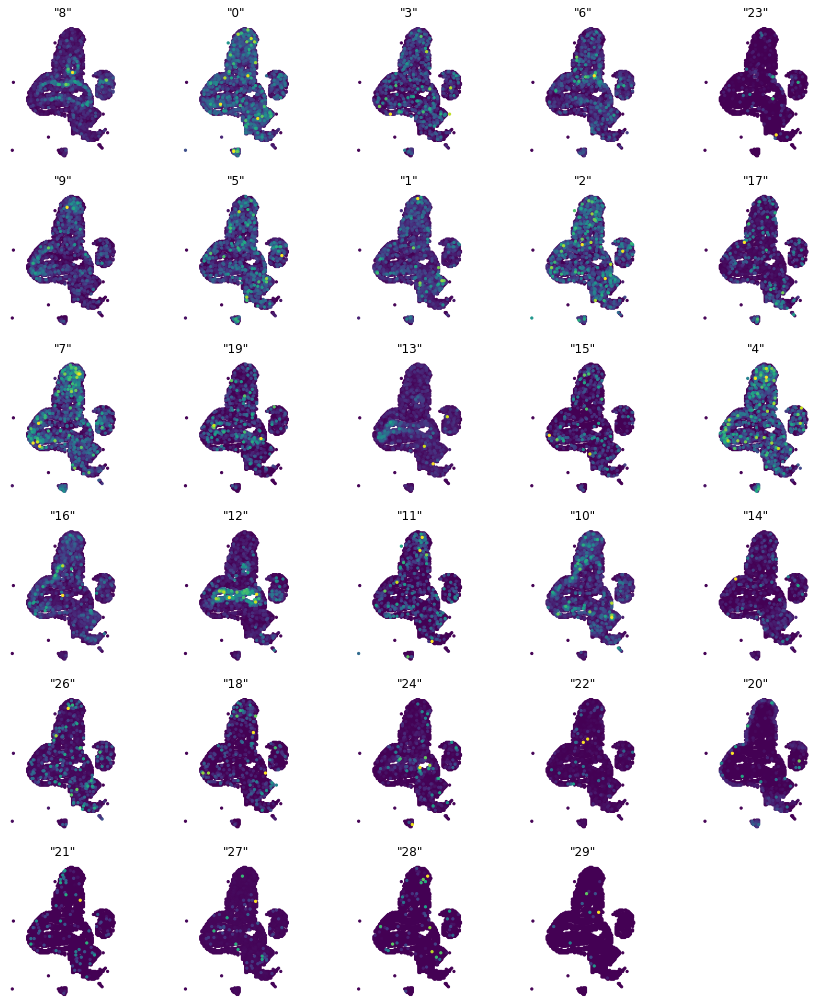

In [51]:
tg.plot_cell_annotation(ad_map, annotation='subclass_label', nrows=6, ncols=5)

In [52]:
ad_map.var

,name,X,Y,cluster_0_,cluster_1_,cluster_10_,y,x
0,cluster_1_,540.5,1220.5,0.156152,0.188063,2.964036e-05,1220.5,540.5
1,cluster_25_,580.5,3700.5,0.064955,0.072839,5.368714e-06,3700.5,580.5
2,cluster_20_,1100.5,3020.5,0.007186,0.008341,1.839034e-04,3020.5,1100.5
3,cluster_20_,1100.5,3060.5,0.000264,0.000157,3.475873e-05,3060.5,1100.5
4,cluster_20_,1100.5,3100.5,0.000949,0.000512,6.834226e-02,3100.5,1100.5
...,...,...,...,...,...,...,...,...
3124,cluster_20_,4220.5,3820.5,0.017771,0.011829,3.018401e-04,3820.5,4220.5
3125,cluster_8_,4220.5,3860.5,0.002211,0.001707,1.330060e-11,3860.5,4220.5
3126,cluster_14_,4220.5,3900.5,0.001794,0.002863,1.896850e-06,3900.5,4220.5
3127,cluster_18_,4260.5,3620.5,0.033359,0.022770,1.342286e-02,3620.5,4260.5


In [38]:
dat=pd.DataFrame(ad_map.X,index=ad_map.obs['subclass_label'],columns=ad_map.var.leiden_m2)

In [39]:
ad_map

AnnData object with n_obs × n_vars = 6578 × 31608
    obs: '"orig.ident"', '"nCount_RNA"', '"nFeature_RNA"', '"Clusters"', '"DoubletFinderFlag"', '"DoubletFinderScore"', '"MT_ratio"', '"NGenes"', '"PassedQC"', '"PassedQC_MT_ratio"', '"PassedQC_TotalUMI"', '"PassedQC_UMIPerGene"', '"PassedQC_UnsplicedRatio"', '"TotalUMI"', '"X_X"', '"X_Y"', '"unspliced_ratio"', '"chemistry"', '"age"', '"orig_ident"', '"name"', '"SampleName"', '"donor"', '"percent.MT"', '"nCount_spliced"', '"nFeature_spliced"', '"nCount_unspliced"', '"nFeature_unspliced"', '"nCount_ambiguous"', '"nFeature_ambiguous"', '"nCount_SCT"', '"nFeature_SCT"', '"SCT_snn_res.0.8"', '"seurat_clusters"', '"SCT_snn_res.0.1"', '"SCT_snn_res.0.2"', '"SCT_snn_res.0.3"', '"SCT_snn_res.0.4"', '"SCT_snn_res.0.5"', '"SCT_snn_res.0.6"', '"SCT_snn_res.0.7"', '"SCT_snn_res.0.9"', '"SCT_snn_res.1"', '"SCT_snn_res.1.1"', '"SCT_snn_res.1.2"', '"SCT_snn_res.1.3"', '"SCT_snn_res.1.4"', '"SCT_snn_res.1.5"', '"SCT_snn_res.1.6"', '"SCT_snn_res.1.7"', 

In [41]:
ads=ad_map.var

In [49]:
res = pd.DataFrame(columns=dat.index.unique(), index=dat.columns.unique())                                                                                                 

for clust in dat.columns.unique(): 
    for e in dat.index.unique():
        dd=dat.loc[:,clust]
        try:
            ee=dd.loc[e,:]
            try:
                res.loc[clust,e]=np.mean(ee.sum(axis=1))
            except:
                res.loc[clust,e]=np.mean(ee)
        except:
            print("something")
            

In [50]:
res=res.fillna(0)

In [51]:
res.iloc[0:39,:]

subclass_label,"""8""","""0""","""3""","""6""","""23""","""9""","""5""","""1""","""2""","""17""",...,"""14""","""26""","""18""","""24""","""22""","""20""","""21""","""27""","""28""","""29"""
leiden_m2,,,,,,,,,,,,,,,,,,,,,
15.0,0.008169,0.014199,0.014219,0.013045,0.010135,0.015642,0.015627,0.010994,0.018815,0.009074,...,0.013343,0.007557,0.010878,0.002079,0.003390,0.011979,0.008921,0.032966,0.001820,1.424940e-07
11.0,0.028557,0.022813,0.029874,0.023189,0.005974,0.038747,0.023822,0.022139,0.029223,0.017268,...,0.023943,0.017900,0.043805,0.005212,0.020493,0.014128,0.026164,0.011202,0.013329,1.537053e-07
25.0,0.004715,0.006293,0.008176,0.005712,0.019602,0.004132,0.007822,0.009905,0.006656,0.015123,...,0.017387,0.004634,0.006011,0.018220,0.035654,0.020108,0.004657,0.007806,0.001368,1.619338e-07
4.0,0.187114,0.170434,0.148771,0.194936,0.148687,0.114757,0.190334,0.166912,0.160746,0.112499,...,0.191615,0.141446,0.131826,0.090524,0.124645,0.111700,0.162024,0.085661,0.074174,6.540473e-05
21.0,0.004665,0.023193,0.013292,0.012568,0.009912,0.008914,0.010416,0.013538,0.016735,0.014130,...,0.011309,0.008991,0.017980,0.022890,0.021864,0.017615,0.032334,0.008532,0.003016,1.229185e-07
18.0,0.085780,0.052668,0.040581,0.049514,0.044950,0.151553,0.043176,0.064827,0.067280,0.044426,...,0.052915,0.052276,0.080482,0.026254,0.030603,0.045633,0.044914,0.043601,0.009859,2.401791e-06
6.0,0.060041,0.030294,0.087701,0.041603,0.018214,0.027796,0.029214,0.028525,0.038654,0.051558,...,0.047143,0.085088,0.018202,0.023538,0.017723,0.034876,0.019219,0.023839,0.084649,2.993587e-05
12.0,0.039718,0.055477,0.047336,0.038153,0.052463,0.067376,0.058688,0.064268,0.051258,0.082570,...,0.057946,0.048517,0.080061,0.039391,0.078920,0.054490,0.071819,0.046241,0.079567,2.164956e-05
5.0,0.127197,0.077320,0.077467,0.177528,0.070385,0.135237,0.089596,0.069432,0.070861,0.041768,...,0.055045,0.052366,0.078135,0.008714,0.041200,0.060499,0.077435,0.052747,0.027898,3.415038e-06


In [14]:
proj_map=tg.project_cell_annotations(ad_map, annotation= 'subclass_label')

In [54]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)

In [118]:
ad_ges=pd.DataFrame(ad_ge.X)

In [119]:
ad_ges.columns=ad_ge.var.index

In [115]:
GENE='ETV5'

(354.5, 4446.5, 788.5, 5892.5)

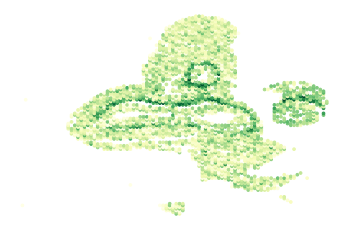

In [120]:
#fig = plt.figure()
#fig.set_figheight(3)
#fig.set_figwidth(3)

plt.scatter(ad_ge.obs['X'],ad_ge.obs['Y'],c=np.log(ad_ges[GENE]+1),cmap='YlGn',s=7)
#    ax[i,j].title(col)
plt.axis('off')
#plt.show()
#plt.set_title(GENE,fontsize=30)

In [121]:
ad_ges.to_csv('J:/MAIN_LUNG_DATA/Data/Imputed/pcw5_imputed_genes.csv')

In [122]:
ad_ge.obs.to_csv('J:/MAIN_LUNG_DATA/Data/Imputed/pcw5_imputed_genes_metadata.csv')